In [28]:
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from scipy import sparse
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor

In [8]:
ET_regressor = ExtraTreesRegressor()

In [14]:
# Evaluation Metrics
def evaluation_metric(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def nrmse(y_true, y_pred):
    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse_val / (y_true.max() - y_true.min())

def test_error_percentage(score):
    return (score/4104996.104768301) * 100

def mae(y_true, y_pred):
    n = len(y_true)
    mae = sum(abs(y_true[i] - y_pred[i]) for i in range(n)) / n
    return mae

def test_rmse(y_true, y_pred):
    print(f"mae : {mae(y_true, y_pred)}")
    print(f"RMSE : {evaluation_metric(y_true, y_pred)}")
    print(f"Normalized RMSE : {nrmse(y_true, y_pred)}")
    score = evaluation_metric(y_true, y_pred)
    print(f"Error Percentage : {test_error_percentage(score)}")

def preprocess_data():
    train = pd.read_csv('train_data_nan_wind.csv', index_col='Date')
    test = pd.read_csv('test_data_nan_wind.csv', index_col='Date')
    train.fillna(-1, inplace=True)
    test.fillna(-1, inplace=True)
    all_data = pd.concat([train, test], ignore_index=True)

#     drop_columns = ["Day", "Year", "t2m", "CloudForm", "GroundState(code)", 
#                     "PhenomenonNumber", "Humidity(%)", "Visibility(10m)", "aerosol", "power"]
    drop_columns = ["Day", "Year", "t2m", "CloudForm", "GroundState(code)", 
                "PhenomenonNumber", "aerosol", "d2m", "VaporPressure(hPa)", "Humidity(%)", 
                    "Visibility(10m)", "MidLowCloudCoverage(1/10)", "LowCloud(100m)",
                   "SnowfallLast3Hours(cm)"]
#     drop_columns = ['Day', 'Precipitation(mm)',
#        'Humidity(%)', 'VaporPressure(hPa)', 'DewPointTemperature(C)',
#        'Sunshine(hr)', 'Snowfall(cm)',
#        'SnowfallLast3Hours(cm)', 'TotalCloudCoverage(1/10)',
#        'MidLowCloudCoverage(1/10)', 'CloudForm', 'LowCloud(100m)',
#        'Visibility(10m)', 'GroundState(code)', 'PhenomenonNumber', 'd2m',
#        't2m', 'aerosol', 'power', 'Year']
    all_data = all_data.drop(columns=drop_columns)
    #all_data['num_missing'] = (all_data == -1).sum(axis=1)
    
    #all_data['Snowfall_Class'] = all_data['Snowfall(cm)'].apply(classify_level)
    #all_data['Precipitation_Class'] = all_data['Precipitation(mm)'].apply(classify_level)
    
    #all_data['Precipitation(mm)'] = all_data['Precipitation(mm)'] + 0.001
    #all_data['Precipitation(mm)'] = np.log1p(all_data['Precipitation(mm)'])
    

    #all_data[standard_cols] = scaler.fit_transform(all_data[standard_cols])

    all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data)], format='csr')
    num_train = len(train)
    X = all_data_sprs[:num_train]
    X_test = all_data_sprs[num_train:]
    y = train['power'].values
    y_test = test['power'].values
    return X, y, X_test, y_test

In [15]:
X, y, X_test, y_test = preprocess_data()
ET_regressor = ExtraTreesRegressor()
ET_regressor.fit(X, y)
Regressor_pred = ET_regressor.predict(X_test)
test_rmse(y_test, Regressor_pred)

mae : 720.913924334005
RMSE : 4536.5111424703655
Normalized RMSE : 0.0003735598766856362
Error Percentage : 0.11051194755582895


In [16]:
def calculate_pearsonr(data1, data2):
    return pearsonr(data1, data2)

def daily_visualize(y_test_array, preds, test_index):
    # y_test와 test_index를 데이터프레임으로 변환
    y_test_df = pd.DataFrame(y_test_array, index=pd.to_datetime(test_index), columns=['power'])
    
    # 일자별로 그룹화하고 합계를 계산
    daily_actual_sum = y_test_df.groupby(y_test_df.index.date)['power'].sum().values
    daily_predicted_sum = [np.sum(preds[y_test_df.index.date == date]) for date in np.unique(y_test_df.index.date)]
    
    # 상관계수 계산
    corr_coefficient, p_value = calculate_pearsonr(daily_actual_sum, daily_predicted_sum)

    plt.figure(figsize=(15, 6))
    plt.plot(daily_actual_sum, label='Actual Daily Power Sum', color='blue')
    plt.plot(daily_predicted_sum, label='Predicted Daily Power Sum', color='red', alpha=0.7)
    plt.title('Daily Power Sum')
    plt.ylabel('Power Sum')
    plt.legend()
    plt.grid(True, axis='y')
    
    # 상관계수를 그래프 상에 주석으로 추가
    corr_text = f"Pearson correlation coefficient: {corr_coefficient:.6f}\nP-value: {p_value:.6f}"
    plt.annotate(corr_text, xy=(0.75, 0.15), xycoords='axes fraction', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="aliceblue"))

    plt.show()


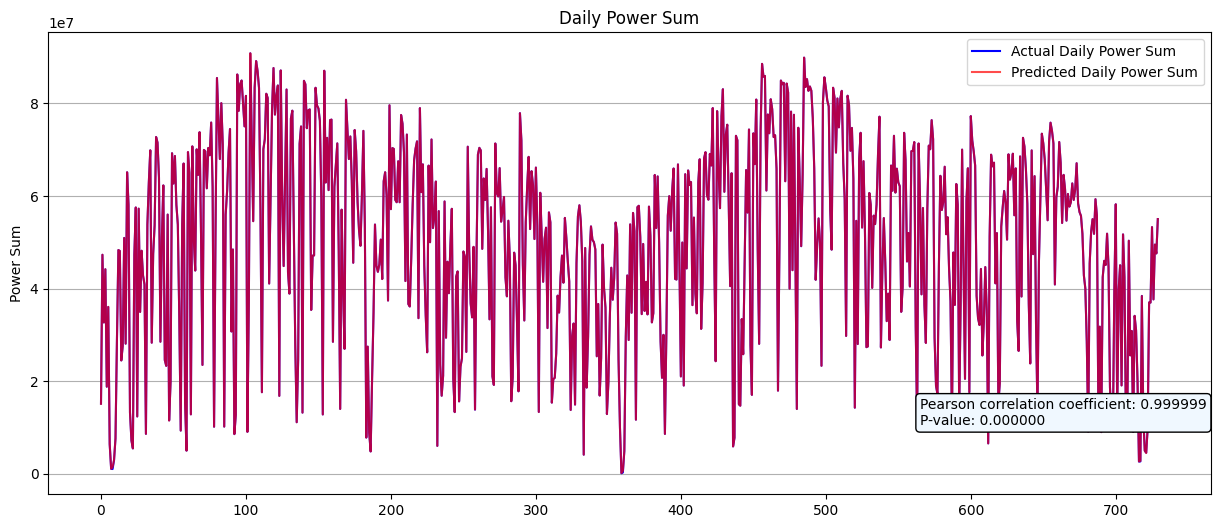

In [17]:
test = pd.read_csv('test_data_nan.csv', index_col='DateTime')
daily_visualize(y_test, Regressor_pred, test.index)

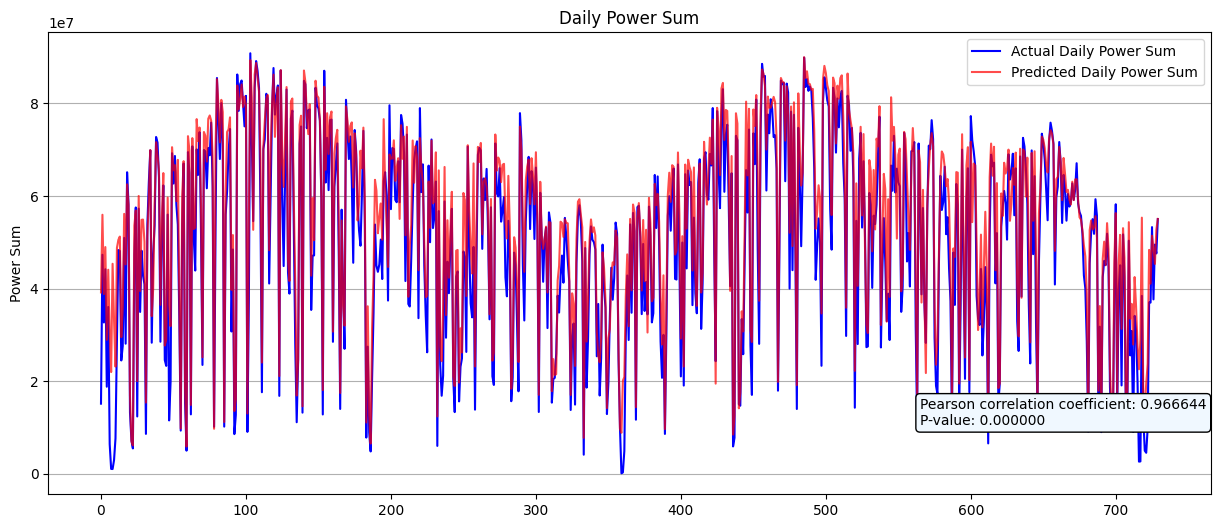

In [12]:
test = pd.read_csv('test_data_nan.csv', index_col='DateTime')
daily_visualize(y_test, Regressor_pred, test.index)

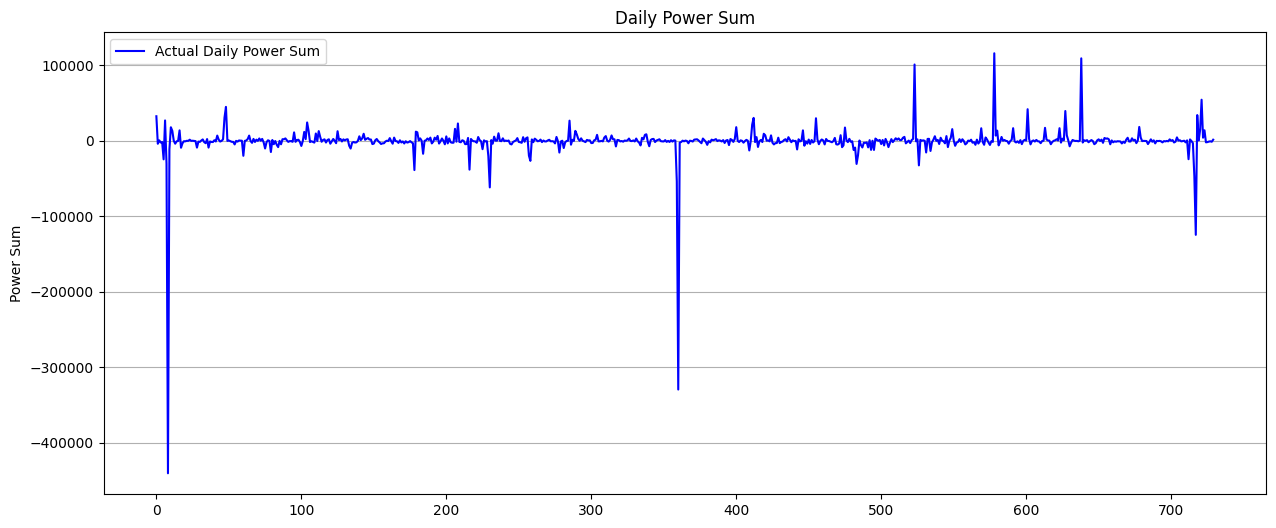

In [18]:
test = pd.read_csv('test_data_nan.csv', index_col='DateTime')

y_test_df = pd.DataFrame(y_test, index=pd.to_datetime(test.index), columns=['power'])

# 일자별로 그룹화하고 합계를 계산
daily_actual_sum = y_test_df.groupby(y_test_df.index.date)['power'].sum().values
daily_predicted_sum = [np.sum(Regressor_pred[y_test_df.index.date == date]) for date in np.unique(y_test_df.index.date)]

plt.figure(figsize=(15, 6))
plt.plot(daily_actual_sum - daily_predicted_sum, label='Actual Daily Power Sum', color='blue')
plt.title('Daily Power Sum')
plt.ylabel('Power Sum')
plt.legend()
plt.grid(True, axis='y')
plt.show()

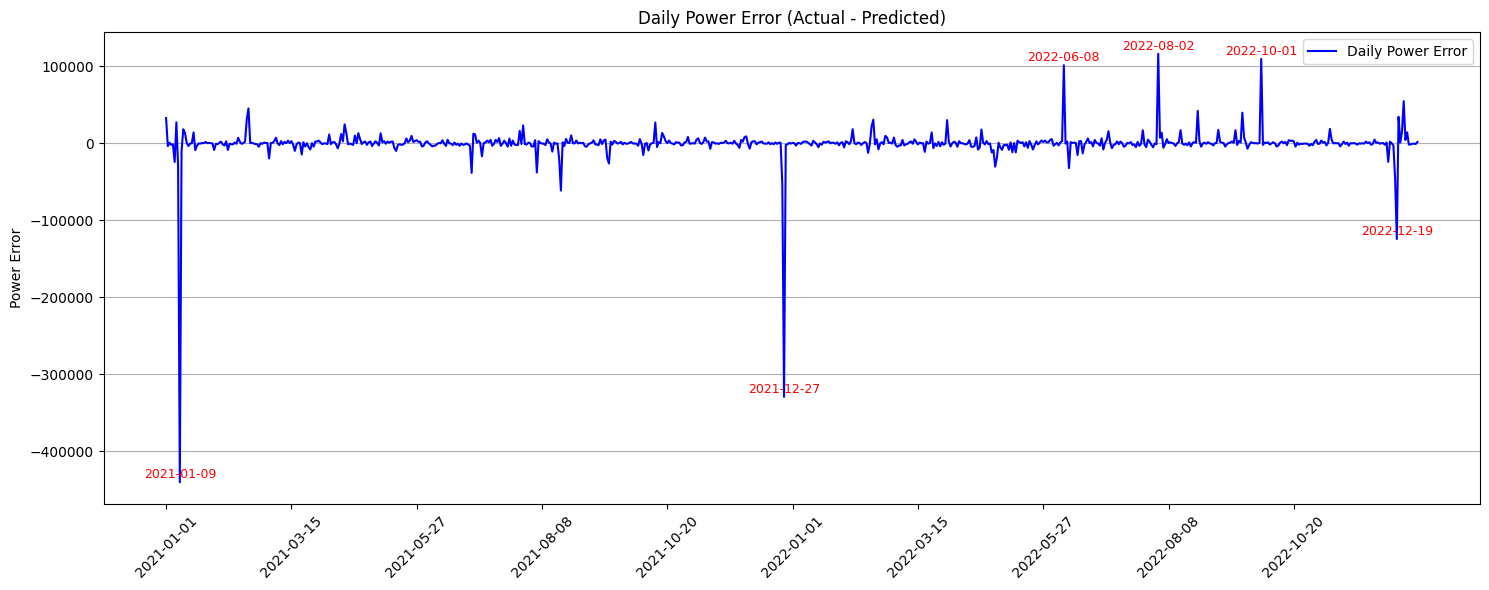

In [20]:

test = pd.read_csv('test_data_nan.csv', index_col='DateTime')

y_test_df = pd.DataFrame(y_test, index=pd.to_datetime(test.index), columns=['power'])

# 일자별로 그룹화하고 합계를 계산
daily_actual_sum = y_test_df.groupby(y_test_df.index.date)['power'].sum().values
daily_predicted_sum = [np.sum(Regressor_pred[y_test_df.index.date == date]) for date in np.unique(y_test_df.index.date)]

# 오차 계산
error = daily_actual_sum - daily_predicted_sum

# 오차와 관련된 날짜 정보를 데이터프레임으로 만들기
error_df = pd.DataFrame({
    'date': np.unique(y_test_df.index.date),
    'error': error
})

# 오차를 내림차순으로 정렬
sorted_error_df = error_df.sort_values(by='error', ascending=False)

# 상위 20개의 오차를 가진 날짜 선택
top_20_error_dates = sorted_error_df.head(6)

top_20_absolute_error_dates = error_df.iloc[np.argsort(-np.abs(error_df['error'].values))[:6]]


# 그래프 그리기
plt.figure(figsize=(15, 6))
plt.plot(error, label='Daily Power Error', color='blue')
plt.title('Daily Power Error (Actual - Predicted)')
plt.ylabel('Power Error')
plt.legend()
plt.grid(True, axis='y')

# x축에 날짜 정보 설정
dates = np.unique(y_test_df.index.date)
plt.xticks(ticks=range(0, len(dates), int(len(dates)/10)), labels=[dates[i].strftime('%Y-%m-%d') for i in range(0, len(dates), int(len(dates)/10))], rotation=45)

# 상위 20개 오차를 그래프에 주석으로 추가
for idx, row in top_20_absolute_error_dates.iterrows():
    date = row['date']
    err = row['error']
    date_idx = list(dates).index(date)
    plt.annotate(f"{date.strftime('%Y-%m-%d')}", (date_idx, err), 
                 textcoords="offset points", xytext=(0,3), ha='center', fontsize=9, color='red')

plt.tight_layout()
plt.show()

In [22]:
X, y, X_test, y_test = preprocess_data()
rf_run = RandomForestRegressor()
rf_run.fit(X, y)
Regressor_pred_rf = rf_run.predict(X_test)
test_rmse(y_test, Regressor_pred_rf)

mae : 18.917170360420865
RMSE : 390.7504595616469
Normalized RMSE : 3.217642124190109e-05
Error Percentage : 0.009518899642992526


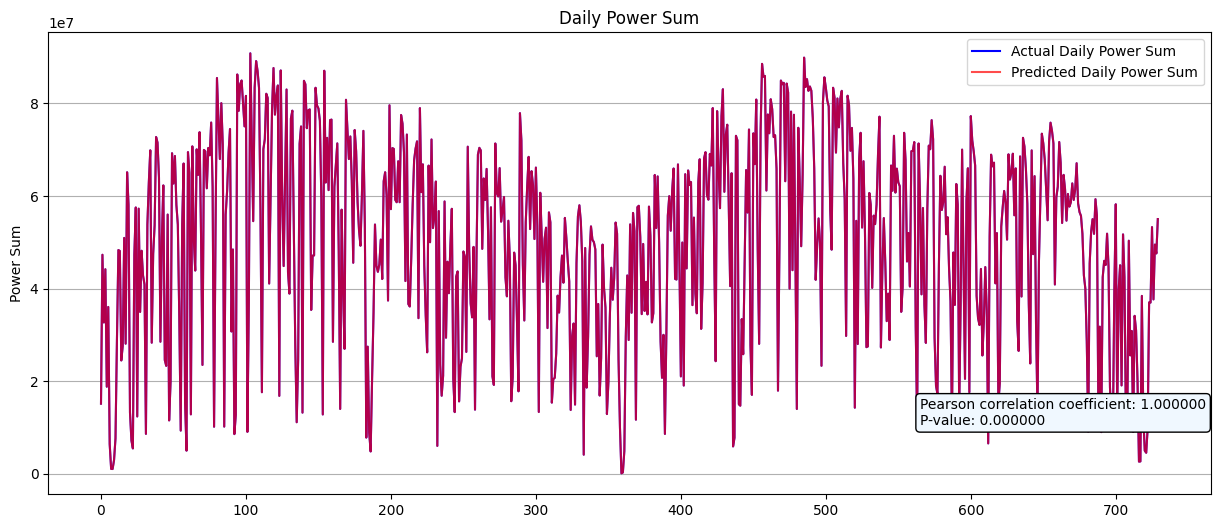

In [24]:
test = pd.read_csv('test_data_nan.csv', index_col='DateTime')
daily_visualize(y_test, Regressor_pred_rf, test.index)

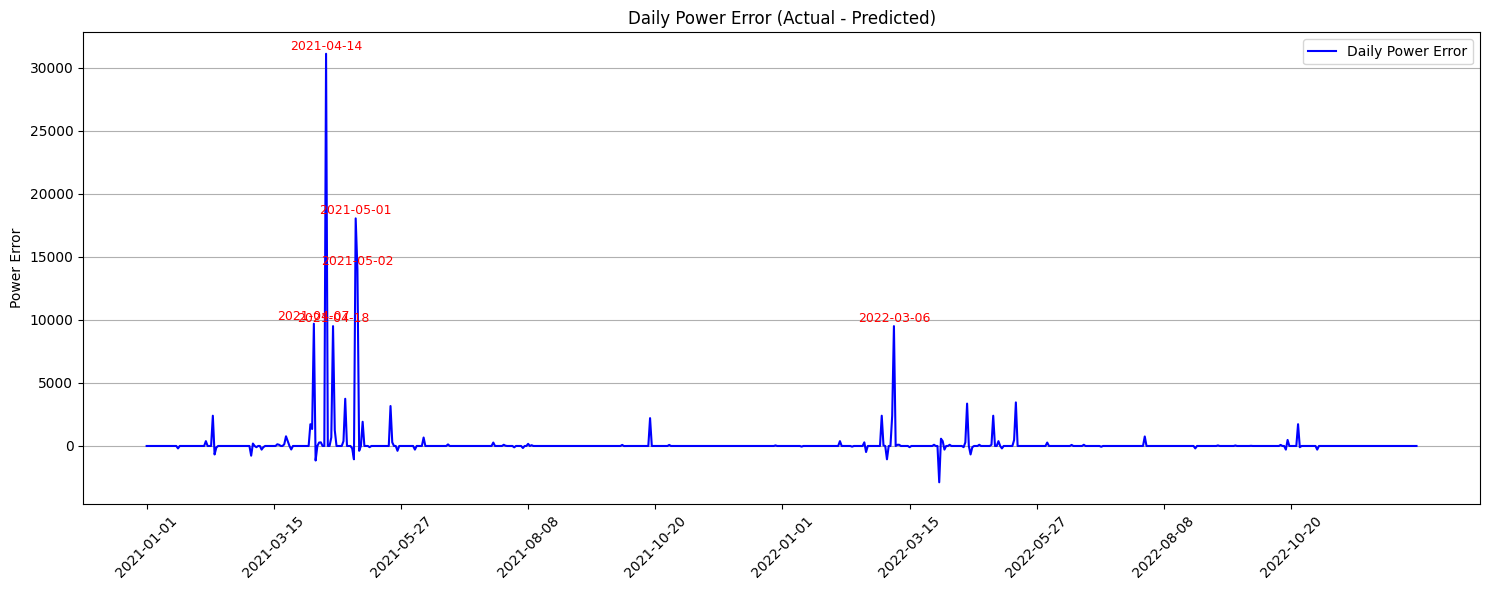

In [25]:

test = pd.read_csv('test_data_nan.csv', index_col='DateTime')

y_test_df = pd.DataFrame(y_test, index=pd.to_datetime(test.index), columns=['power'])

# 일자별로 그룹화하고 합계를 계산
daily_actual_sum = y_test_df.groupby(y_test_df.index.date)['power'].sum().values
daily_predicted_sum = [np.sum(Regressor_pred_rf[y_test_df.index.date == date]) for date in np.unique(y_test_df.index.date)]

# 오차 계산
error = daily_actual_sum - daily_predicted_sum

# 오차와 관련된 날짜 정보를 데이터프레임으로 만들기
error_df = pd.DataFrame({
    'date': np.unique(y_test_df.index.date),
    'error': error
})

# 오차를 내림차순으로 정렬
sorted_error_df = error_df.sort_values(by='error', ascending=False)

# 상위 20개의 오차를 가진 날짜 선택
top_20_error_dates = sorted_error_df.head(6)

top_20_absolute_error_dates = error_df.iloc[np.argsort(-np.abs(error_df['error'].values))[:6]]


# 그래프 그리기
plt.figure(figsize=(15, 6))
plt.plot(error, label='Daily Power Error', color='blue')
plt.title('Daily Power Error (Actual - Predicted)')
plt.ylabel('Power Error')
plt.legend()
plt.grid(True, axis='y')

# x축에 날짜 정보 설정
dates = np.unique(y_test_df.index.date)
plt.xticks(ticks=range(0, len(dates), int(len(dates)/10)), labels=[dates[i].strftime('%Y-%m-%d') for i in range(0, len(dates), int(len(dates)/10))], rotation=45)

# 상위 20개 오차를 그래프에 주석으로 추가
for idx, row in top_20_absolute_error_dates.iterrows():
    date = row['date']
    err = row['error']
    date_idx = list(dates).index(date)
    plt.annotate(f"{date.strftime('%Y-%m-%d')}", (date_idx, err), 
                 textcoords="offset points", xytext=(0,3), ha='center', fontsize=9, color='red')

plt.tight_layout()
plt.show()

In [29]:
train = pd.read_csv('train_data_nan_wind.csv', index_col='Date')
len(train)

34741